This notebook develops and tests a routine for calculating cloud base height from RegCM data.  This is designed to be used in a TECA-like framework, such that the routine operates on one timestep at a time of model state information.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as PP
import xarray as xr
import numpy as np
import numba

mpl.style.use('seaborn-poster')

In [2]:
with xr.open_dataset('test_data/1950fog_ATM.2005070100.nc') as fin:
    fin0 = fin.isel(time = -1)#, iy = slice(0,2), jx = slice(0,2))
    # read variables necessary for determining geopotential height
    hus = fin0.hus
    ps = fin0.ps
    sigma = fin0.kz
    ts = fin0.ts
    ta = fin0.ta
    ptop = fin0.ptop * 100
    
    # read variables necessary for fog detection
    clw = fin0.clw

In [3]:
@numba.njit('float64[:,:](float64[:,:,:],float64[:,:,:], float64[:,:,:], float64[:,:], float64[:,:], float64[:], float64, float64, float64)')
def calculate_cloud_base_sigma(clw,
                               ta,
                               hus,
                               ps,
                               ts,
                               sigma,
                               ptop,
                               missing_value = -1e-20,
                               clw_threshold = 5e-5):
    """Calculates cloud base height following the formulation of O'Brien et al. (2013, doi:10.1007/s00382-012-1486-x).
    
        input:
        ------
        
            clw           : cloud liquid water content [kg/kg]
                            np.float64[:,:,:]
                            
            ta            : air temperature [K]
                            np.float64[:,:,:]
          
            hus           : specific humidity [kg/kg]
                            np.float64[:,:,:]
          
            ps            : surface pressure [Pa]
                            np.float64[:,:]
          
            ts            : surface temperature [K]
                            np.float64[:,:]
          
            sigma         : the model sigma coordinate
                            np.float64[:,:]
                            
            ptop          : the model top pressure
                            np.float64
    
            missing_value : the value to use to flag that no cloud is detected in the column
                            np.float64
    
            clw_threshold : the threshold on clw for determining cloud presence
                            (5e-5 kg/kg is the value used by O'Brien et al.)
                            np.float64
                            
        output:
        -------
        
            z_cloud_base  : the cloud base height [m]
                            np.float64[:,:]
    
    
        This routine is designed to operate on one timestep of raw state-variable information from a sigma-coordinate model like RegCM. It uses the
        hypsometric equation to determine geopotential height on the fly.
        
        It is assumed that the z-dimension is stored such that the values at the top of the atmosphere have the lowest indices.
    """
    # get the shape of the array
    kz = ta.shape[0]
    iy = ta.shape[1]
    jx = ta.shape[2]
    
    # initialize the output array
    z_cloud_base = np.empty_like(ts)
    
    # set some constants
    Rd = 287.
    g = 9.81
    delta = 0.608
    
    for i in range(iy):
        for j in range(jx):
            
            # start by assuming no cloud is in this column
            z_cloud_base[i,j] = missing_value
            
            # calculate pressure
            p = sigma*(ps[i,j] - ptop) + ptop
            
            # calculate virtual temperature
            tv = ta[:,i,j]*(1 + delta*hus[:,i,j])
            
            # initialize the topography-relative height
            z = 0
            
            # loop over layers from bottom to top
            for k in range(kz-1,-1,-1):
               
                # calculate the layer thickness
                if k == kz -1:
                    # treat the surface layer differently
                    # calculate the first height increment (relative to surface)
                    dz0 = (Rd*(tv[kz-1] + ts[i,j])/(2*g)) * np.log(ps[i,j]/p[kz-1])
                    z = dz0
                else:
                    dz = (Rd*(tv[k+1] + tv[k])/(2*g)) * np.log(p[k+1]/p[k])
                
                # continue integrating the geopotential height upward
                z += dz
                
                # determine if this layer satisfies the fog condition
                if clw[k,i,j] >= clw_threshold:
                    # store the cloud base and go to the next cell
                    z_cloud_base[i,j] = z
                    break
    return z_cloud_base

In [4]:
fill_value = -1e-20
zbase = calculate_cloud_base_sigma(
                                   clw.values.astype(float),
                                   ta.values.astype(float),
                                   hus.values.astype(float),
                                   ps.values.astype(float),
                                   ts.values.astype(float),
                                   sigma.values.astype(float),
                                   float(ptop),fill_value, 5e-5)


# make this into an xarray with mising values properly flagged
zbase = xr.DataArray(zbase, dims = ("iy", "jx"), coords = dict(iy = ts.iy, jx = ts.jx))
zbase = zbase.where( zbase != fill_value)

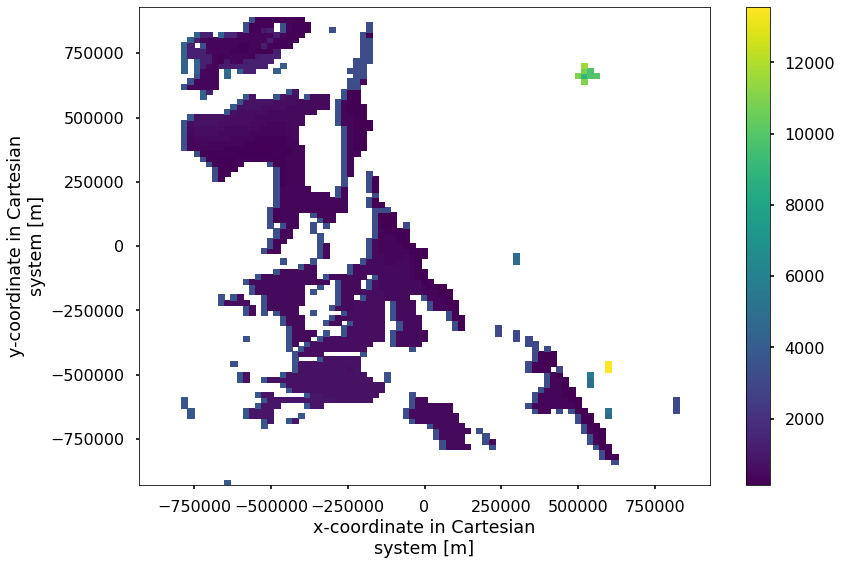

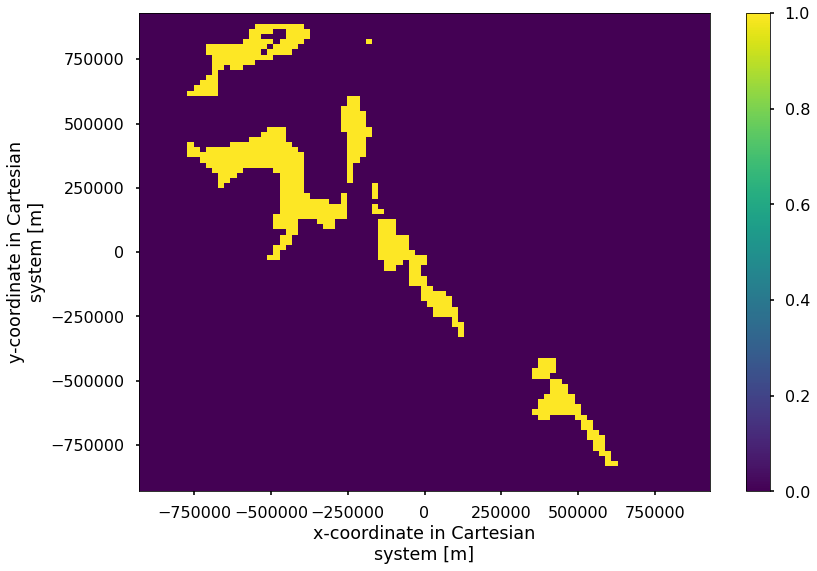

In [5]:
# plot it
zbase.plot(); PP.show()
(zbase <= 400).plot(); PP.show()